In [10]:
from PIL import Image
from cityscapesscripts.helpers import labels
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import gc
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

In [11]:
# Set seeds for reproducibility
def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.mps.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
SEED = 42
set_seeds(SEED)
print(f"Seeds set for reproducibility is {SEED}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() 
                      else "mps" if torch.mps.is_available() 
                      else "cpu"
                    )
print(DEVICE)

from contextlib import contextmanager
import ssl
# Disable SSL verification for urllib requests on MacOS
# This is a workaround for the "SSL: CERTIFICATE_VERIFY_FAILED" error on MacOS
@contextmanager
def no_ssl_verification():
    """Temporarily disable SSL verification"""
    old_context = ssl._create_default_https_context
    ssl._create_default_https_context = ssl._create_unverified_context
    try:
        yield
    finally:
        ssl._create_default_https_context = old_context

Seeds set for reproducibility is 42
cuda


In [12]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, targets_dir, image_transform=None, target_transform=None):
        """
        Args:
            images_dir (string): Directory with all the images.
            targets_dir (string): Directory with all the target masks.
            image_transform (callable, optional): Optional transform to be applied on images.
            target_transform (callable, optional): Optional transform to be applied on targets.
        """
        self.images_dir = images_dir
        self.targets_dir = targets_dir
        self.image_transform = image_transform
        self.target_transform = target_transform
        
        # Get all image filenames
        self.image_filenames = [f for f in os.listdir(images_dir) 
                               if f.lower().endswith(('.png'))]
        self.image_filenames.sort()
        
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Load target mask
        target_name = img_name.replace('.png', '_trainId.png')
        target_path = os.path.join(self.targets_dir, target_name)
        target = Image.open(target_path)
        
        # Apply transforms
        if self.image_transform:
            image = self.image_transform(image)
        
        if self.target_transform:
            target = self.target_transform(target)
       # else:
       #     # Default: convert to tensor
       #     target = torch.from_numpy(target)
        
        return image, target

In [ ]:
# Create color map for segmentation (using Cityscapes colors)
from cityscapesscripts.helpers import labels as cs_labels
def visualize_segmentation(model, dataloader, num_samples=4, start_idx=0, deterministic=False):
    """
    Visualize segmentation results from the model
    
    Args:
        model: The model to evaluate
        dataloader: DataLoader containing images and targets
        num_samples: Number of samples to visualize
        start_idx: Starting index for deterministic sampling (used when deterministic=True)
        deterministic: If True, select images deterministically by index
    """
    model.eval()
    
    # Get images for visualization
    if deterministic:
        # For true determinism, access the dataset directly instead of the dataloader
        # This avoids the randomness caused by shuffle=True
        dataset = dataloader.dataset
        
        # Handle the case where the dataset is a Subset (from random_split)
        if hasattr(dataset, 'dataset') and hasattr(dataset, 'indices'):
            # This is a Subset from random_split
            #print("Handling Subset dataset case")
            orig_dataset = dataset.dataset
            indices = dataset.indices
            
            # Select specific indices
            selected_indices = indices[start_idx:start_idx + num_samples]
            
            # Get samples directly from the original dataset
            images = []
            targets = []
            for idx in selected_indices:
                img, tgt = orig_dataset[idx]
                images.append(img.unsqueeze(0))  # Add batch dimension
                targets.append(tgt.unsqueeze(0))
            
            # Stack to form batches
            images = torch.cat(images, dim=0)
            targets = torch.cat(targets, dim=0)
        else:
            # Regular dataset
            images = []
            targets = []
            for i in range(start_idx, min(start_idx + num_samples, len(dataset))):
                img, tgt = dataset[i]
                images.append(img.unsqueeze(0))
                targets.append(tgt.unsqueeze(0))
            
            # Stack to form batches
            images = torch.cat(images, dim=0)
            targets = torch.cat(targets, dim=0)
    else:
        # Non-deterministic: Just get the next batch
        images, targets = next(iter(dataloader))
        
        # Limit to the required number of samples
        images = images[:num_samples]
        targets = targets[:num_samples]
    
    # Ensure we don't use more than available
    #num_samples = min(num_samples, len(images))
    
    images = images[:num_samples].to(DEVICE)
    targets = targets[:num_samples].to(DEVICE)
    
    with torch.no_grad():
        outputs = model(images)['out']
        predictions = torch.argmax(outputs, dim=1)
    
    # Move to CPU for visualization
    images = images.cpu()
    targets = targets.cpu()
    predictions = predictions.cpu()
    
    def apply_color_map(seg_map):
        """Apply color mapping to segmentation map"""
        colored_map = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)
        
        # Get valid labels (excluding ignore classes)
        valid_labels = [label for label in cs_labels.labels if label.trainId != 255 and label.trainId != -1]
        
        for label in valid_labels:
            mask = seg_map == label.trainId
            colored_map[mask] = label.color
            
        return colored_map
    
    # Plot results
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 4))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(min(num_samples, len(images))):
        # Original image
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        # Ground truth
        gt_colored = apply_color_map(targets[i].numpy())
        axes[i, 1].imshow(gt_colored)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        # Prediction
        pred_colored = apply_color_map(predictions[i].numpy())
        axes[i, 2].imshow(pred_colored)
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

Actual Colors:


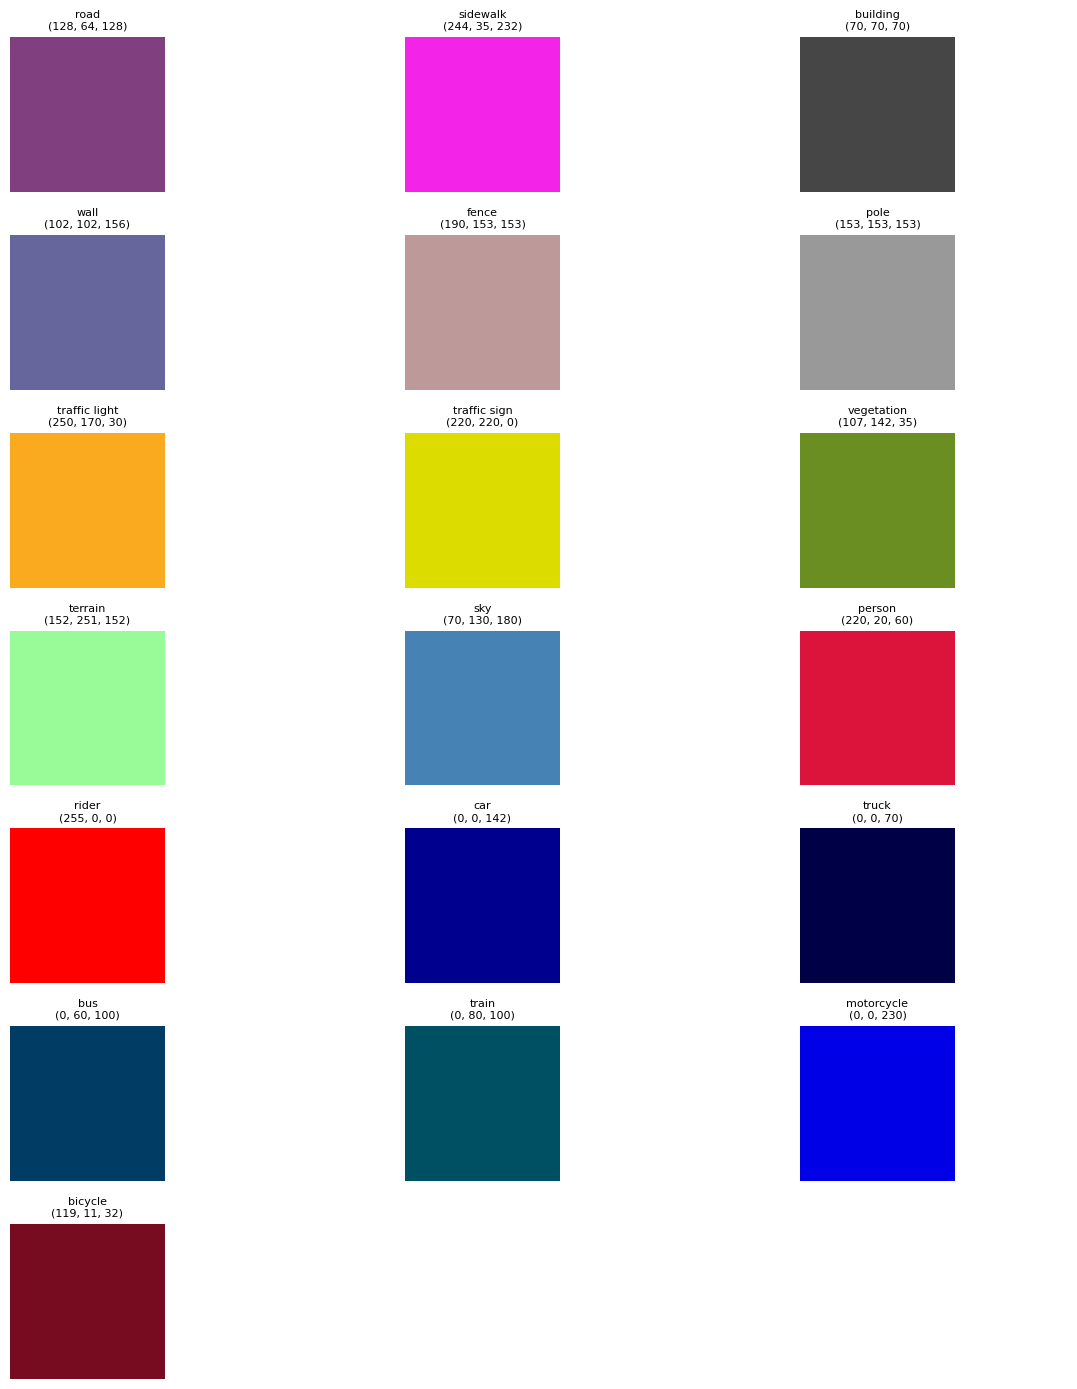

In [14]:
print("Actual Colors:")

# Calculate grid dimensions (3 colors per row)
cols = 3

labels = [label for label in labels.labels if label.trainId != 255 and label.trainId != -1]
rows = (len(labels) + cols - 1) // cols  # Ceiling division

# Create a figure and axes to display the colors in a grid
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 2))

# Flatten axes array for easier indexing
if rows == 1:
    axes = [axes] if cols == 1 else axes
else:
    axes = axes.flatten()

for i, label in enumerate(labels): 
    color = np.array(label.color) / 255.0  # Normalize RGB values to [0, 1]
    axes[i].imshow([[color]])  # Display the color as a small image
    # Add color name and RGB values to the title
    axes[i].set_title(f"{label.name}\n{label.color}", fontsize=8)
    axes[i].axis('off')  # Hide the axes

# Hide any unused subplots
for i in range(len(labels), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# DeeplabV3


## DeeplabV3 resnet50

In [15]:
path_images = "syn_resized_images"
path_target = "syn_resized_gt"

image_transform = transforms.Compose([
    transforms.Resize((256, 466)), # We maintain the og aspect ratio
    transforms.ToTensor(),  # Converts PIL Image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize with ImageNet parameters
])

target_transform = transforms.Compose([
    transforms.Resize((256, 466), interpolation=Image.NEAREST), # This interpolation ensure that all pixels have a correct value of their class
    transforms.Lambda(lambda x: torch.from_numpy(np.array(x)).long())
])
syn_dataset = SegmentationDataset(images_dir=path_images, targets_dir=path_target, image_transform=image_transform, target_transform=target_transform)

In [16]:
# Get total dataset size
total_size = len(syn_dataset)
print(f"Total dataset size: {total_size}")

# Calculate split sizes (60% train, 10% val, 30% test)
train_size = int(0.6 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

print(f"Train size: {train_size} ({train_size/total_size*100:.1f}%)")
print(f"Validation size: {val_size} ({val_size/total_size*100:.1f}%)")
print(f"Test size: {test_size} ({test_size/total_size*100:.1f}%)")

# Create random splits
syn_train_dataset, syn_val_dataset, syn_test_dataset = random_split(
    syn_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)  # For reproducibility
)

# Create DataLoaders
batch_size = 8  


syn_train_dataloader = DataLoader(
    syn_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED) 
)


syn_val_dataloader = DataLoader(
    syn_val_dataset,
    batch_size=batch_size,
    shuffle=True,  
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

syn_test_dataloader = DataLoader(
    syn_test_dataset,
    batch_size=batch_size,
    shuffle=True,  
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

print(f"\nDataLoaders created:")
print(f"Train batches: {len(syn_train_dataloader)}")
print(f"Validation batches: {len(syn_val_dataloader)}")
print(f"Test batches: {len(syn_test_dataloader)}")

if DEVICE.type == 'mps': 
    print("mps detected, using no_ssl_verification")
    with no_ssl_verification():
        model = deeplabv3_resnet50(
            weights='COCO_WITH_VOC_LABELS_V1', 
        )
else:
    model = deeplabv3_resnet50(
        weights='COCO_WITH_VOC_LABELS_V1', 
    )
NUM_CLASSES = 19  # Cityscapes
LR = 1e-4

model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model = model.to(DEVICE)

# Load the best model checkpoint
best_model_path = "models/deeplabv3_resnet50_best_model.pth"
print(f"Loading best model from: {best_model_path}")

checkpoint = torch.load(best_model_path, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])

print(f"Best model loaded successfully!")
print(f"Best validation IoU: {checkpoint['val_iou']:.4f}")
print(f"From epoch: {checkpoint['epoch']}")

Total dataset size: 12500
Train size: 7500 (60.0%)
Validation size: 1250 (10.0%)
Test size: 3750 (30.0%)

DataLoaders created:
Train batches: 938
Validation batches: 157
Test batches: 469
Loading best model from: models/deeplabv3_resnet50_best_model.pth
Best model loaded successfully!
Best validation IoU: 0.5830
From epoch: 25


Running first deterministic visualization with start_idx=0:
Handling Subset dataset case


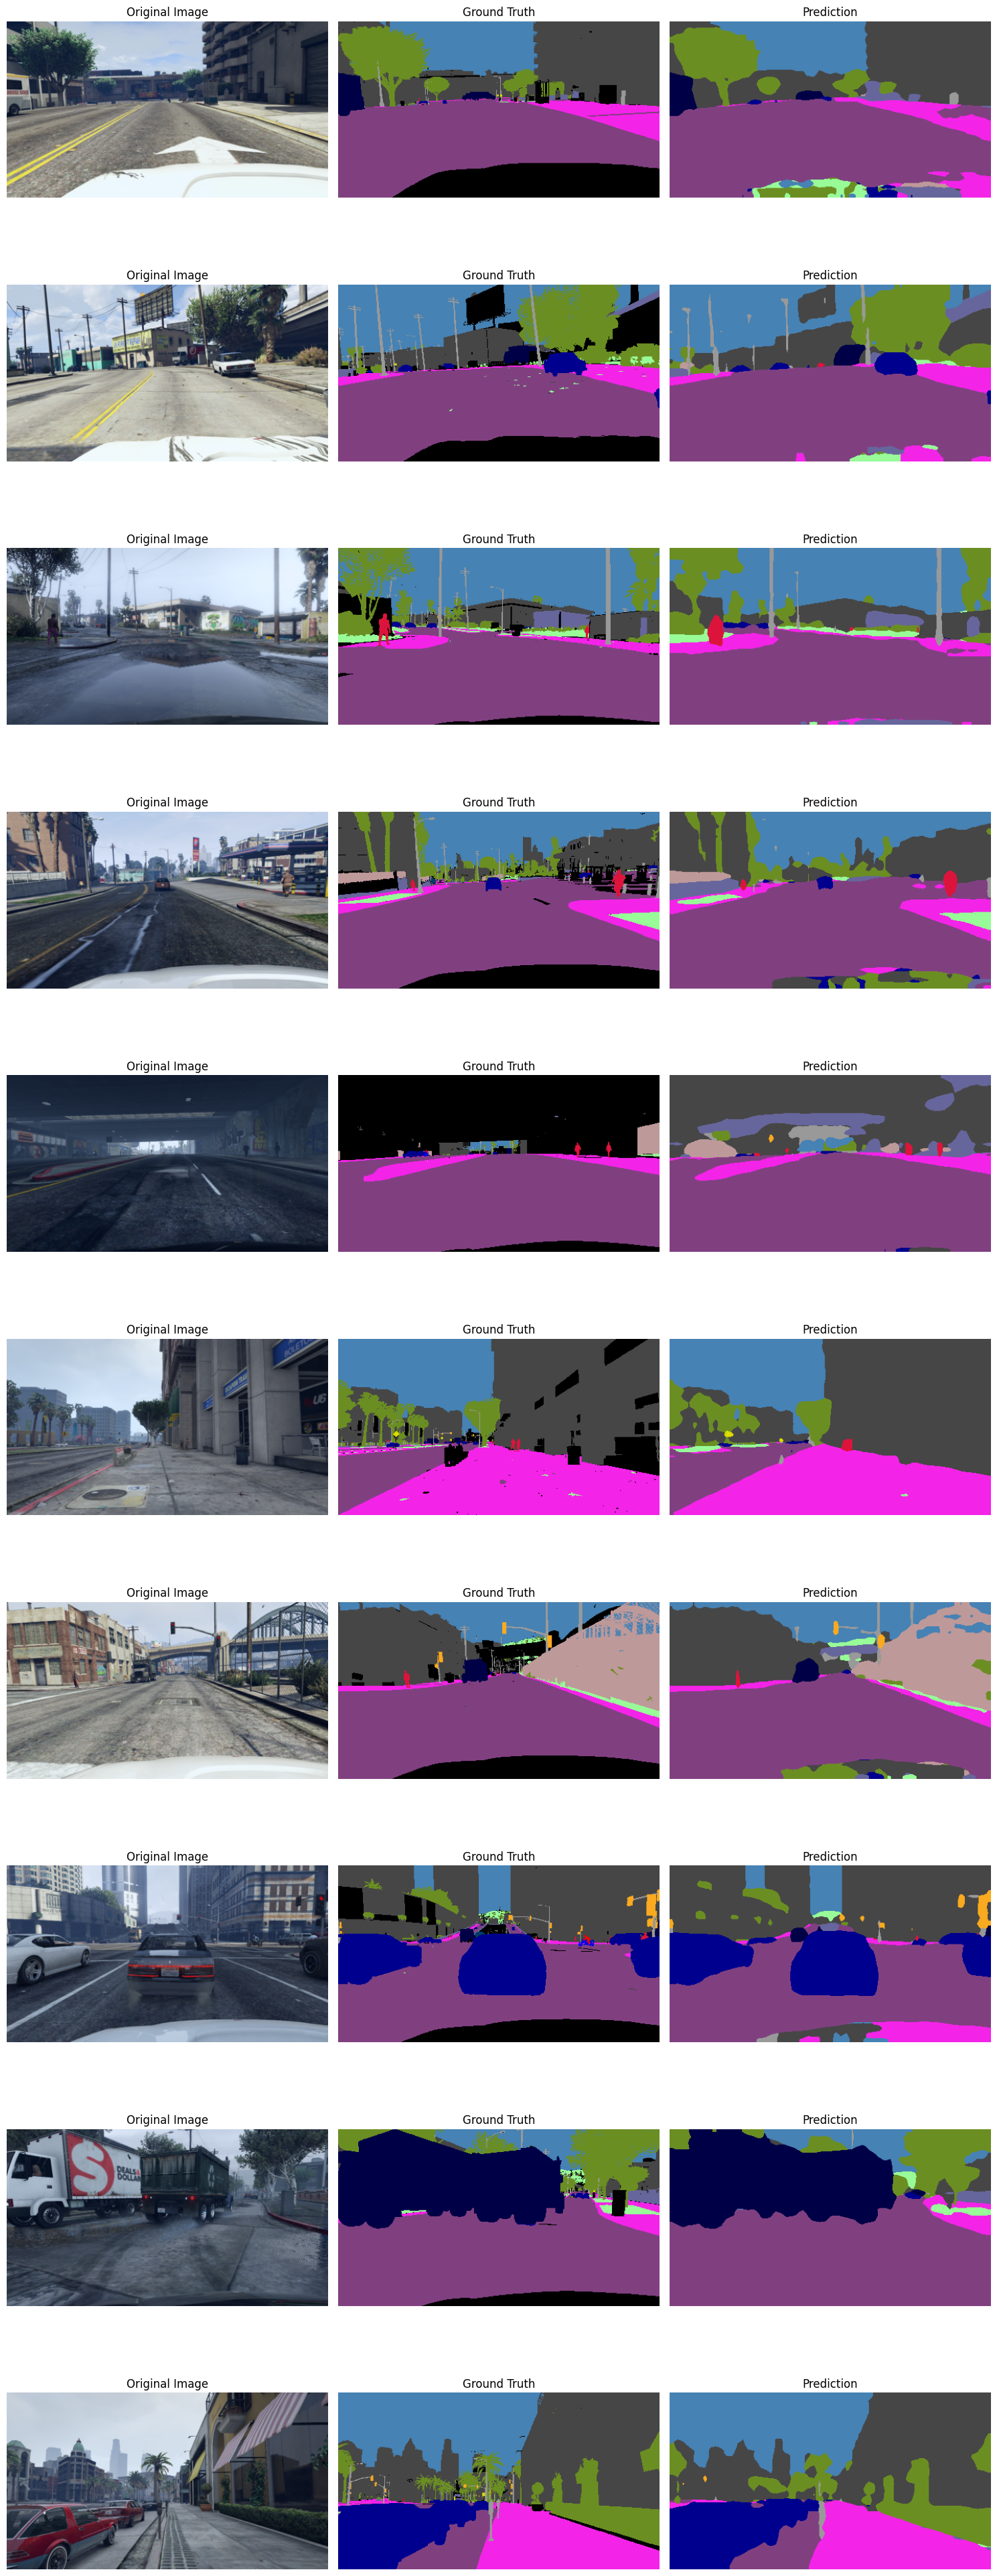

In [17]:
print("Running first deterministic visualization with start_idx=0:")
visualize_segmentation(model, syn_val_dataloader, num_samples=10, start_idx=0, deterministic=True)